In [1]:
using Flux, ParameterSchedulers, Optimisers, Statistics, CUDA 
using Flux: Conv, BatchNorm, MaxPool, flatten, Dense, Dropout, relu, softmax
using Base.Iterators: repeated, partition
using Printf, BSON, JLD2, LinearAlgebra
using ImageCore, Images
using MLDatasets: convert2image, CIFAR10
using Plots              
using StatsBase

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\oliwi\.julia\packages\Flux\9PibT\ext\FluxCUDAExt\FluxCUDAExt.jl:10


In [2]:
ENV["DATADEPS_ALWAYS_ACCEPT"] = "true"

"true"

In [3]:
use_cuda = true

true

In [4]:
if use_cuda && CUDA.functional()
    device = gpu
    @info "Training on GPU"
else
    device = cpu
    @info "Training on CPU"
end

┌ Info: Training on CPU
└ @ Main c:\Users\oliwi\Desktop\SGH\masgisterka\II_sem\Deep Learning\projekt_zaliczeniowy\DeepLearningProjektZaliczeniowy\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W3sZmlsZQ==.jl:6


In [5]:
function make_minibatch(X, Y, idxs)
    X_batch = Array{Float32}(undef, 32, 32, 3, length(idxs))
    for (i, idx) in enumerate(idxs)
        X_batch[:,:,:,i] = X[:,:,:,idx]
    end
    Y_batch = Flux.onehotbatch(Y[idxs], 0:9)
    return X_batch, Y_batch
end

make_minibatch (generic function with 1 method)

In [6]:
test_set = CIFAR10(:test)
test_set = make_minibatch(test_set.features, test_set.targets, 1:size(test_set.features)[4]) |> device

(Float32[0.61960787 0.59607846 … 0.23921569 0.21176471; 0.62352943 0.5921569 … 0.19215687 0.21960784; … ; 0.49411765 0.49019608 … 0.11372549 0.13333334; 0.45490196 0.46666667 … 0.078431375 0.08235294;;; 0.4392157 0.4392157 … 0.45490196 0.41960785; 0.43529412 0.43137255 … 0.4 0.4117647; … ; 0.35686275 0.35686275 … 0.32156864 0.32941177; 0.33333334 0.34509805 … 0.2509804 0.2627451;;; 0.19215687 0.2 … 0.65882355 0.627451; 0.18431373 0.15686275 … 0.5803922 0.58431375; … ; 0.14117648 0.1254902 … 0.49411765 0.5058824; 0.12941177 0.13333334 … 0.41960785 0.43137255;;;; 0.92156863 0.93333334 … 0.32156864 0.33333334; 0.90588236 0.92156863 … 0.18039216 0.24313726; … ; 0.9137255 0.9254902 … 0.7254902 0.7058824; 0.9098039 0.92156863 … 0.73333335 0.7294118;;; 0.92156863 0.93333334 … 0.3764706 0.39607844; 0.90588236 0.92156863 … 0.22352941 0.29411766; … ; 0.9137255 0.9254902 … 0.78431374 0.7647059; 0.9098039 0.92156863 … 0.7921569 0.78431374;;; 0.92156863 0.93333334 … 0.32156864 0.3254902; 0.90588236

In [7]:
model_small_convnet = Chain(
  # — blok 1: 32×32 → 16×16, kanały 3 → 16 —
  Conv((3,3), 3=>16, pad=1), BatchNorm(16), relu,
  MaxPool((2,2)),                           # 16×16

  # — blok 2: 16×16 → 8×8, kanały 16 → 32 —
  Conv((3,3), 16=>32, pad=1), BatchNorm(32), relu,
  MaxPool((2,2)),                           # 8×8

  # — blok 3: 8×8 → 4×4, kanały 32 → 64 —
  Conv((3,3), 32=>64, pad=1), BatchNorm(64), relu,
  MaxPool((2,2)),                           # 4×4

  # — flatten + head FC —
  flatten,                                  # 64*4*4 = 1024
  Dense(1024, 128), relu, Dropout(0.5),
  Dense(128,   10),
  softmax
) |> device

BSON.@load "model_small_convnet.bson" ps

Flux.loadmodel!(model_small_convnet, device(ps))

Chain(
  Conv((3, 3), 3 => 16, pad=1),         # 448 parameters
  BatchNorm(16),                        # 32 parameters, plus 32
  NNlib.relu,
  MaxPool((2, 2)),
  Conv((3, 3), 16 => 32, pad=1),        # 4_640 parameters
  BatchNorm(32),                        # 64 parameters, plus 64
  NNlib.relu,
  MaxPool((2, 2)),
  Conv((3, 3), 32 => 64, pad=1),        # 18_496 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  NNlib.relu,
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(1024 => 128),                   # 131_200 parameters
  NNlib.relu,
  Dropout(0.5),
  Dense(128 => 10),                     # 1_290 parameters
  NNlib.softmax,
)         # Total: 16 trainable arrays, 156_298 parameters,
          # plus 6 non-trainable, 224 parameters, summarysize 613.047 KiB.

In [8]:
struct ResBlock
  f::Chain
end

function ResBlock(channels::Integer)
  return ResBlock(Chain(
    Conv((3,3), channels=>channels, pad=1),
    BatchNorm(channels), relu,
    Conv((3,3), channels=>channels, pad=1),
    BatchNorm(channels)
  ))
end

# aplikacja bloku: F(x)+x, potem ReLU
(m::ResBlock)(x) = relu(m.f(x) .+ x)

model_resNet = Chain(
  # Block 1: 3→32
  Conv((3,3), 3=>32, pad=1), BatchNorm(32), relu,
  ResBlock(32),
  MaxPool((2,2)),      # 32×32 → 16×16

  # Block 2: 32→64
  Conv((3,3), 32=>64, pad=1), BatchNorm(64), relu,
  ResBlock(64),
  MaxPool((2,2)),      # 16×16 → 8×8

  # Flatten i head
  flatten,             # 64*8*8 = 4096
  Dense(4096, 128),    BatchNorm(128), relu, Dropout(0.5),
  Dense(128, 10),
  softmax
) |> device

BSON.@load "model_resNet.bson" ps

Flux.loadmodel!(model_resNet, device(ps))

Chain(
  Conv((3, 3), 3 => 32, pad=1),         # 896 parameters
  BatchNorm(32),                        # 64 parameters, plus 64
  NNlib.relu,
  ResBlock(
    Chain(
      Conv((3, 3), 32 => 32, pad=1),    # 9_248 parameters
      BatchNorm(32),                    # 64 parameters, plus 64
      NNlib.relu,
      Conv((3, 3), 32 => 32, pad=1),    # 9_248 parameters
      BatchNorm(32),                    # 64 parameters, plus 64
    ),
  ),
  MaxPool((2, 2)),
  Conv((3, 3), 32 => 64, pad=1),        # 18_496 parameters
  BatchNorm(64),                        # 128 parameters, plus 128
  NNlib.relu,
  ResBlock(
    Chain(
      Conv((3, 3), 64 => 64, pad=1),    # 36_928 parameters
      BatchNorm(64),                    # 128 parameters, plus 128
      NNlib.relu,
      Conv((3, 3), 64 => 64, pad=1),    # 36_928 parameters
      BatchNorm(64),                    # 128 parameters, plus 128
    ),
  ),
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(4096 => 128),                   # 524_416 para

In [9]:
model_vgg = Chain(
  # --- blok 1: 3 → 64 ---
  Conv((3,3), 3=>64, pad=1), relu,
  Conv((3,3), 64=>64, pad=1), relu,
  MaxPool((2,2)),               # 32×32 → 16×16

  # --- blok 2: 64 → 128 ---
  Conv((3,3), 64=>128, pad=1), relu,
  Conv((3,3), 128=>128, pad=1), relu,
  MaxPool((2,2)),               # 16×16 → 8×8

  # --- blok 3: 128 → 256 ---
  Conv((3,3), 128=>256, pad=1), relu,
  Conv((3,3), 256=>256, pad=1), relu,
  MaxPool((2,2)),               # 8×8 → 4×4

  # spłaszczamy
  flatten,                      # 256×4×4 = 4096

  # --- klasyfikator ---
  Dense(4096, 512), relu, Dropout(0.5),
  Dense(512, 256), relu, Dropout(0.5),
  Dense(256, 10),
  softmax
) |> device

BSON.@load "model_vgg.bson" ps

Flux.loadmodel!(model_vgg, device(ps))

Chain(
  Conv((3, 3), 3 => 64, pad=1),         # 1_792 parameters
  NNlib.relu,
  Conv((3, 3), 64 => 64, pad=1),        # 36_928 parameters
  NNlib.relu,
  MaxPool((2, 2)),
  Conv((3, 3), 64 => 128, pad=1),       # 73_856 parameters
  NNlib.relu,
  Conv((3, 3), 128 => 128, pad=1),      # 147_584 parameters
  NNlib.relu,
  MaxPool((2, 2)),
  Conv((3, 3), 128 => 256, pad=1),      # 295_168 parameters
  NNlib.relu,
  Conv((3, 3), 256 => 256, pad=1),      # 590_080 parameters
  NNlib.relu,
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(4096 => 512),                   # 2_097_664 parameters
  NNlib.relu,
  Dropout(0.5),
  Dense(512 => 256),                    # 131_328 parameters
  NNlib.relu,
  Dropout(0.5),
  Dense(256 => 10),                     # 2_570 parameters
  NNlib.softmax,
)                   # Total: 18 arrays, 3_376_970 parameters, 12.884 MiB.

In [10]:
model_allcnn = Chain(
  # -- blok 1 --
  Conv((3,3), 3=>96, pad=1), relu,
  Conv((3,3), 96=>96, pad=1), relu,
  Conv((3,3), 96=>96, stride=2, pad=1), relu,   # downsample 32→16

  # -- blok 2 --
  Conv((3,3), 96=>192, pad=1), relu,
  Conv((3,3), 192=>192, pad=1), relu,
  Conv((3,3), 192=>192, stride=2, pad=1), relu, # downsample 16→8

  # -- blok 3 (klasyfikator) --
  Conv((3,3), 192=>192, pad=1), relu,
  Conv((1,1), 192=>192, pad=0), relu,
  Conv((1,1), 192=>10,  pad=0),              # mapujemy do 10 kanałów

  # -- global average pooling + softmax --
  x -> mean(x, dims=(1,2)),  # (10×1×1×N)
  flatten,                   # → (10, N)
  softmax
) |> device

BSON.@load "model_allcnn.bson" ps

Flux.loadmodel!(model_allcnn, device(ps))

Chain(
  Conv((3, 3), 3 => 96, pad=1),         # 2_688 parameters
  NNlib.relu,
  Conv((3, 3), 96 => 96, pad=1),        # 83_040 parameters
  NNlib.relu,
  Conv((3, 3), 96 => 96, pad=1, stride=2),  # 83_040 parameters
  NNlib.relu,
  Conv((3, 3), 96 => 192, pad=1),       # 166_080 parameters
  NNlib.relu,
  Conv((3, 3), 192 => 192, pad=1),      # 331_968 parameters
  NNlib.relu,
  Conv((3, 3), 192 => 192, pad=1, stride=2),  # 331_968 parameters
  NNlib.relu,
  Conv((3, 3), 192 => 192, pad=1),      # 331_968 parameters
  NNlib.relu,
  Conv((1, 1), 192 => 192),             # 37_056 parameters
  NNlib.relu,
  Conv((1, 1), 192 => 10),              # 1_930 parameters
  var"#11#12"(),
  Flux.flatten,
  NNlib.softmax,
)                   # Total: 18 arrays, 1_369_738 parameters, 5.227 MiB.

In [11]:
X_test, Y_test = test_set 

(Float32[0.61960787 0.59607846 … 0.23921569 0.21176471; 0.62352943 0.5921569 … 0.19215687 0.21960784; … ; 0.49411765 0.49019608 … 0.11372549 0.13333334; 0.45490196 0.46666667 … 0.078431375 0.08235294;;; 0.4392157 0.4392157 … 0.45490196 0.41960785; 0.43529412 0.43137255 … 0.4 0.4117647; … ; 0.35686275 0.35686275 … 0.32156864 0.32941177; 0.33333334 0.34509805 … 0.2509804 0.2627451;;; 0.19215687 0.2 … 0.65882355 0.627451; 0.18431373 0.15686275 … 0.5803922 0.58431375; … ; 0.14117648 0.1254902 … 0.49411765 0.5058824; 0.12941177 0.13333334 … 0.41960785 0.43137255;;;; 0.92156863 0.93333334 … 0.32156864 0.33333334; 0.90588236 0.92156863 … 0.18039216 0.24313726; … ; 0.9137255 0.9254902 … 0.7254902 0.7058824; 0.9098039 0.92156863 … 0.73333335 0.7294118;;; 0.92156863 0.93333334 … 0.3764706 0.39607844; 0.90588236 0.92156863 … 0.22352941 0.29411766; … ; 0.9137255 0.9254902 … 0.78431374 0.7647059; 0.9098039 0.92156863 … 0.7921569 0.78431374;;; 0.92156863 0.93333334 … 0.32156864 0.3254902; 0.90588236

In [12]:
function loss(model, x, y, device = device)
    x = x |>cpu
    x_aug = x .+ 0.1f0*randn(eltype(x), size(x)) |> device
    y_hat = model(x_aug)
    return Flux.crossentropy(y_hat, y) 
end

loss (generic function with 2 methods)

In [10]:
loss(model_small_convnet, test_set[1],test_set[2])

0.8666772f0

In [ ]:
# function loss_batched(model, X, Y; batchsize=64)
#   total_loss = 0f0
#   total_n    = 0
#   N = size(X, 4)
#   for i in 1:batchsize:N
#     j = min(i+batchsize-1, N)
#     xb = device(X[:,:,:, i:j])
#     yb = device(Y[:,   i:j])
#     # 1) oblicz stratę na batchu
#     l = Flux.crossentropy(model(xb), yb)
#     # 2) sumuj stratę ważoną liczbą próbek
#     nb = size(xb, 4)
#     total_loss += l * nb
#     total_n    += nb
#   end
#   return total_loss / total_n
# end

loss_batched (generic function with 1 method)

In [11]:
# loss_batched(model_small_convnet, X_test, Y_test; batchsize=64)

In [13]:
accuracy(model,x, y) = mean(Flux.onecold(model(x)) .== Flux.onecold(y))

accuracy (generic function with 1 method)

In [13]:
accuracy(model_small_convnet,test_set[1],test_set[2])

0.7007

In [14]:
models = [
  ("SmallConvNet",  model_small_convnet),
  ("ResNet",        model_resNet),
  ("VGG",           model_vgg),
  ("AllCNN",        model_allcnn),
]

4-element Vector{Tuple{String, Chain}}:
 ("SmallConvNet", Chain(Conv((3, 3), 3 => 16, pad=1), BatchNorm(16), relu, MaxPool((2, 2)), Conv((3, 3), 16 => 32, pad=1), BatchNorm(32), relu, MaxPool((2, 2)), Conv((3, 3), 32 => 64, pad=1), BatchNorm(64), relu, MaxPool((2, 2)), flatten, Dense(1024 => 128), relu, Dropout(0.5), Dense(128 => 10), softmax))
 ("ResNet", Chain(Conv((3, 3), 3 => 32, pad=1), BatchNorm(32), relu, ResBlock(Chain(Conv((3, 3), 32 => 32, pad=1), BatchNorm(32), relu, Conv((3, 3), 32 => 32, pad=1), BatchNorm(32))), MaxPool((2, 2)), Conv((3, 3), 32 => 64, pad=1), BatchNorm(64), relu, ResBlock(Chain(Conv((3, 3), 64 => 64, pad=1), BatchNorm(64), relu, Conv((3, 3), 64 => 64, pad=1), BatchNorm(64))), MaxPool((2, 2)), flatten, Dense(4096 => 128), BatchNorm(128), relu, Dropout(0.5), Dense(128 => 10), softmax))
 ("VGG", Chain(Conv((3, 3), 3 => 64, pad=1), relu, Conv((3, 3), 64 => 64, pad=1), relu, MaxPool((2, 2)), Conv((3, 3), 64 => 128, pad=1), relu, Conv((3, 3), 128 => 128, pad=1),

In [ ]:
# 1) Accuracy batched
function accuracy_batched(model, X, Y; batchsize=128)
    total, correct = 0, 0
    N = size(X, 4)
    for i in 1:batchsize:N
        j = min(i+batchsize-1, N)
        xb = X[:,:,:,i:j]          
        yb = Y[:,i:j]
        ŷ = model(xb)              
        p = Flux.onecold(ŷ, 0:9)
        t = Flux.onecold(yb, 0:9)
        correct += sum(p .== t)
        total   += length(t)
    end
    return correct / total
end

# 2) Użycie dla wszystkich modeli
models = [
  ("SmallConvNet",  model_small_convnet),
  ("ResNet-like",   model_resNet),
  ("VGG-style",     model_vgg),
  ("All-CNN",       model_allcnn),
]

@printf("%-15s  %s\n", "Model", "Accuracy")
for (name, m) in models
    acc = accuracy_batched(m, X_test, Y_test; batchsize=256)
    @printf("%-15s  %5.2f%%\n", name, 100*acc)
end


Model            Accuracy
SmallConvNet     70.07%
ResNet-like      75.84%
VGG-style        74.56%
All-CNN          72.73%


In [ ]:
using StatsPlots

# 1) Przygotuj prawdziwe etykiety pod nową zmienną
true_labels = Flux.onecold(Y_test, 0:9)  

# 2) Funkcja do batched predykcji
function batched_preds(model, X; batchsize=256)
    N = size(X, 4)
    allp = Vector{Int}()
    for i in 1:batchsize:N
        j = min(i+batchsize-1, N)
        xb = X[:,:,:, i:j]
        ŷ = cpu(model(xb))
        p  = Flux.onecold(ŷ, 0:9)
        append!(allp, p)
    end
    return allp
end

batched_preds (generic function with 1 method)

In [27]:
# 3) Zbierz predykcje dla wszystkich modeli raz
preds_dict = Dict{String,Vector{Int}}()
for (name, m) in models
    preds_dict[name] = batched_preds(m, X_test; batchsize=256)
end

# 4) Oblicz per-class accuracy (w %)
acc_per_class = Dict{String, Vector{Float64}}()
for (name, _) in models
  p = preds_dict[name]
  acc_per_class[name] = [
    mean(p[true_labels .== (c-1)] .== (c-1)) * 100
    for c in 1:10
  ]
end

In [29]:
acc_per_class

Dict{String, Vector{Float64}} with 4 entries:
  "All-CNN"      => [82.3, 85.5, 66.8, 59.6, 56.3, 56.8, 74.1, 79.7, 81.0, 85.2]
  "SmallConvNet" => [77.6, 84.2, 64.5, 60.2, 51.4, 71.2, 52.8, 77.1, 86.0, 75.7]
  "VGG-style"    => [79.8, 89.3, 58.2, 57.5, 66.0, 69.4, 75.3, 81.3, 87.2, 81.6]
  "ResNet-like"  => [79.5, 84.4, 72.0, 67.2, 65.6, 68.9, 62.6, 84.5, 91.6, 82.1]

In [ ]:
# 1) Zbuduj pusty DataFrame i dodaj kolumnę Class
df = DataFrame(Class = classes)

# 2) Dołącz po kolei kolumny z acc_per_class
for (name, vec) in acc_per_class
    col = Symbol(name)
    df[!, col] = vec
end

# 3) Uporządkuj kolumny tak, by Class była pierwsza
ordered = [:Class; Symbol.(collect(keys(acc_per_class)))]
df = select(df, ordered...)

df

Row,Class,All-CNN,SmallConvNet,VGG-style,ResNet-like
,String,Float64,Float64,Float64,Float64
1,plane,82.3,77.6,79.8,79.5
2,car,85.5,84.2,89.3,84.4
3,bird,66.8,64.5,58.2,72.0
4,cat,59.6,60.2,57.5,67.2
5,deer,56.3,51.4,66.0,65.6
6,dog,56.8,71.2,69.4,68.9
7,frog,74.1,52.8,75.3,62.6
8,horse,79.7,77.1,81.3,84.5
9,ship,81.0,86.0,87.2,91.6


In [ ]:
# 1) Zbierz nazwy kolumn modeli
model_cols = names(df, Not(:Class))

# 2) Zbuduj macierz accuracy: wiersz i odpowiada klasie, kolumna modelowi
ys_mat = reduce(hcat, [ df[!, col] for col in model_cols ])  

10×4 Matrix{Float64}:
 82.3  77.6  79.8  79.5
 85.5  84.2  89.3  84.4
 66.8  64.5  58.2  72.0
 59.6  60.2  57.5  67.2
 56.3  51.4  66.0  65.6
 56.8  71.2  69.4  68.9
 74.1  52.8  75.3  62.6
 79.7  77.1  81.3  84.5
 81.0  86.0  87.2  91.6
 85.2  75.7  81.6  82.1

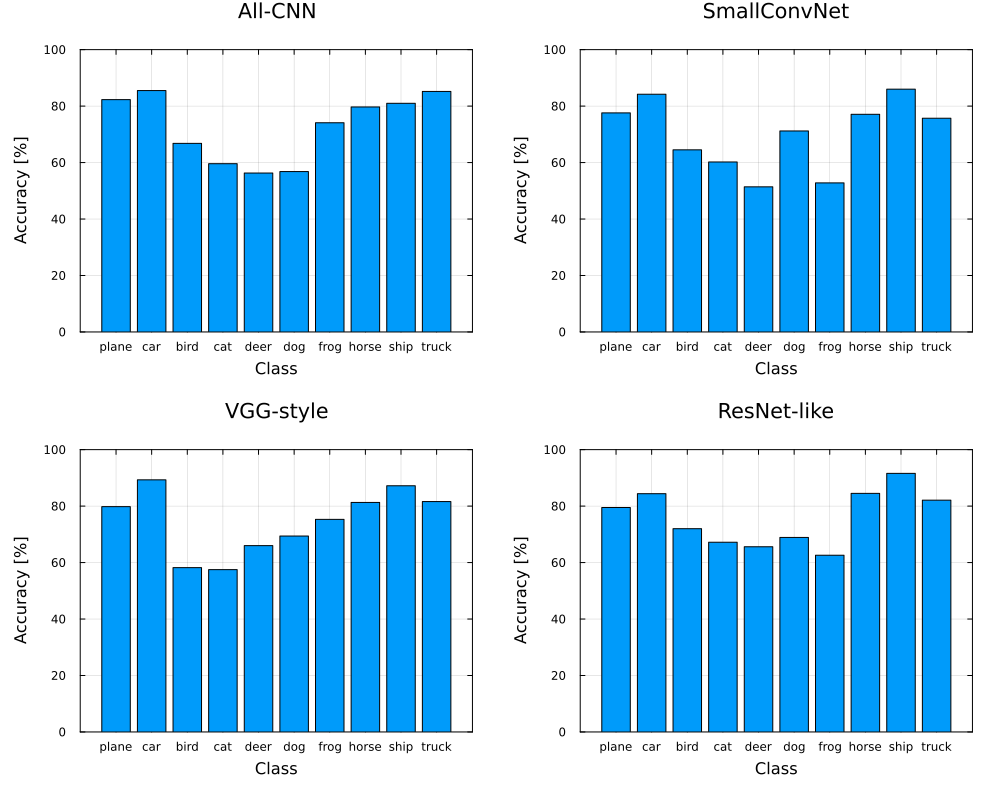

In [47]:
using Plots, DataFrames

# 1) Stwórz listę pojedynczych subplotów
subplots = [
    bar(
      df.Class,
      df[!, col],
      title       = col,
      xlabel      = "Class",
      ylabel      = "Accuracy [%]",
      xtickfont   = font(8),
      ytickfont   = font(8),
      legend      = false,
      framestyle  = :box,
      ylim        = (0, 100),
      size        = (1000,800),
    )
    for col in model_cols
]

# 2) Złącz je w jedną siatkę 2×2
plt = plot(subplots...;
    layout = (2,2),
    margin = 5Plots.mm
)

# 3) Zapisz do pliku
mkpath("plots")
savefig(plt, "plots/per_class_accuracy_grid.png")

# 4) Wyświetl
display(plt)


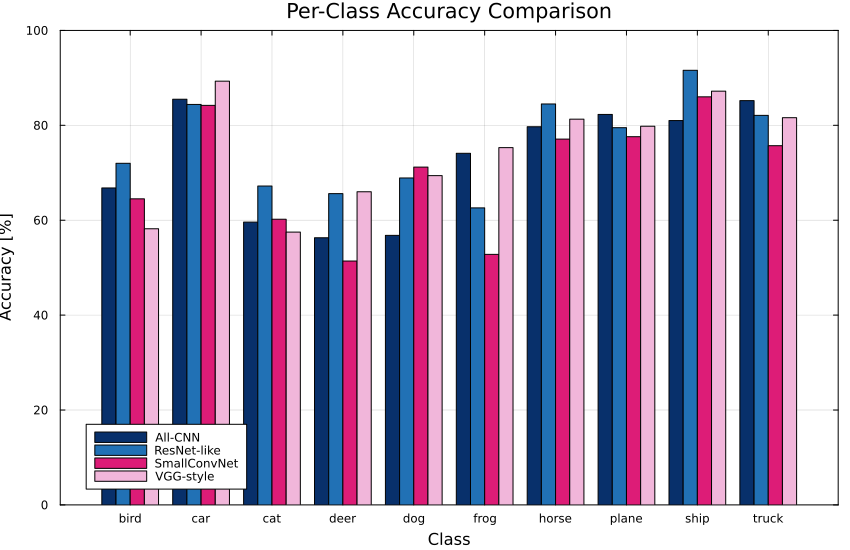

In [ ]:
# 1) Przekształć w "długi" format:
df_long = stack(df, Not(:Class);
                variable_name = :Model,
                value_name    = :Accuracy)

pal = ["#08306B",  # ciemny granat
       "#2171B5",  # niebieski
       "#DD1C77",  # intensywny róż
       "#F1B6DA"]  # jasny róż

# 2) Rysujemy grouped bar:
plt = @df df_long groupedbar(
  :Class, :Accuracy;
  group        = :Model,
  bar_position = :dodge,        
  xlabel       = "Class",
  ylabel       = "Accuracy [%]",
  title        = "Per-Class Accuracy Comparison",
  ylim         = (0,100),    
  framestyle   = :box,
  legend       = :bottomleft,     
  size         = (850,550),
  palette      = pal
)
# 3) Zapisanie do pliku
mkpath("plots")
savefig("plots/per_class_accuracy_all_models.png")

display(plt)

In [ ]:
using StatsBase, DataFrames, Plots

cm = zeros(Int,10,10)
preds = batched_preds(model_allcnn, X_test; batchsize=256)
trues = Flux.onecold(Y_test,             0:9)
for (t,p) in zip(trues, preds)
  if p != t
    cm[t+1, p+1] += 1
  end
end

In [ ]:
tuples = [(t, p, cm[t+1,p+1]) for t in 0:9 for p in 0:9 if t!=p]
top5   = sort(tuples, by = x -> -x[3])[1:5]

classes = ["plane","car","bird","cat","deer","dog","frog","horse","ship","truck"]

df = DataFrame(
  Label = [ "$(classes[t+1]) → $(classes[p+1])" for (t,p,_) in top5 ],
  Count = [ c                       for (_,_,c)    in top5 ]
)

Row,Label,Count
,String,Int64
1,dog → cat,207
2,deer → bird,122
3,cat → dog,104
4,cat → bird,94
5,car → truck,90


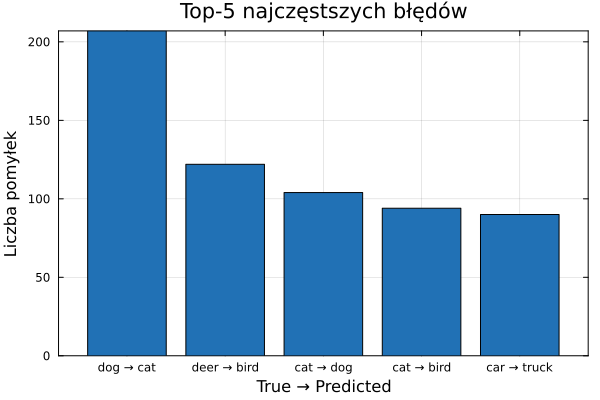

In [ ]:
plt = bar(
  df.Label,
  df.Count;
  xlabel     = "True → Predicted",
  ylabel     = "Liczba pomyłek",
  title      = "Top-5 najczęstszych błędów",
  legend     = false,
  framestyle = :box,
  size       = (600,400),
  color      = "#2171B5"
)

savefig("plots/top5_confusion_errors_model_allcnn.png")
display(plt)

In [ ]:
classes = ["plane","car","bird","cat","deer","dog","frog","horse","ship","truck"]

# 1) Predykcje i prawdziwe etykiety jako wektory 0–9
preds = Flux.onecold(model_allcnn(X_test), 0:9)
actuals = Flux.onecold(Y_test,      0:9)

# 2) Liczniki
class_correct = zeros(Int, 10)
class_total   = zeros(Int, 10)

# 3) Pętla po wszystkich próbkach
for (p, t) in zip(preds, actuals)
    class_total[t+1]   += 1        
    class_correct[t+1] += (p == t)
end

# 4) Accuracy 
class_accuracy = class_correct ./ class_total
for i in 1:10
    @printf("%-6s: %5.2f%%  (%4d/%4d)\n",
        classes[i], 100*class_accuracy[i],
        class_correct[i], class_total[i])
end

plane : 82.30%  ( 823/1000)
car   : 85.50%  ( 855/1000)
bird  : 66.80%  ( 668/1000)
cat   : 59.60%  ( 596/1000)
deer  : 56.30%  ( 563/1000)
dog   : 56.80%  ( 568/1000)
frog  : 74.10%  ( 741/1000)
horse : 79.70%  ( 797/1000)
ship  : 81.00%  ( 810/1000)
truck : 85.20%  ( 852/1000)


In [54]:
using DataFrames, StatsPlots

# Ile razy każda klasa została przypisana jako predykcja
pred_total = zeros(Int, 10)
for p in preds
    pred_total[p+1] += 1
end

# Precision, Recall, F1
precision = class_correct ./ pred_total
recall    = class_correct ./ class_total
f1        = 2 .* (precision .* recall) ./ (precision .+ recall)

# DataFrame z metrykami
df = DataFrame(
  Class     = classes,
  Support   = class_total,
  Predicted = pred_total,
  Correct   = class_correct,
  Precision = round.(precision, digits=3),
  Recall    = round.(recall,    digits=3),
  F1        = round.(f1,        digits=3),
  Accuracy  = round.(class_accuracy, digits=3)
)

display(df)

Row,Class,Support,Predicted,Correct,Precision,Recall,F1,Accuracy
,String,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,plane,1000,1152,823,0.714,0.823,0.765,0.823
2,car,1000,986,855,0.867,0.855,0.861,0.855
3,bird,1000,1144,668,0.584,0.668,0.623,0.668
4,cat,1000,1147,596,0.52,0.596,0.555,0.596
5,deer,1000,726,563,0.775,0.563,0.652,0.563
6,dog,1000,823,568,0.69,0.568,0.623,0.568
7,frog,1000,922,741,0.804,0.741,0.771,0.741
8,horse,1000,1049,797,0.76,0.797,0.778,0.797
9,ship,1000,930,810,0.871,0.81,0.839,0.81


In [55]:
using CSV
mkpath("plots")
CSV.write("plots/class_metrics_model_allcnn.csv", df)

"plots/class_metrics_model_allcnn.csv"

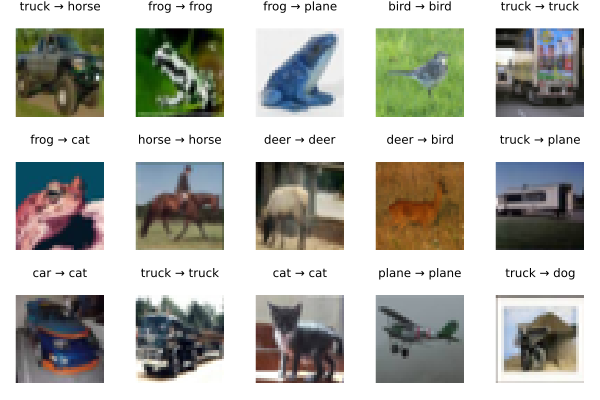

"c:\\Users\\oliwi\\Desktop\\SGH\\masgisterka\\II_sem\\Deep Learning\\projekt_zaliczeniowy\\DeepLearningProjektZaliczeniowy\\plots\\sample_predictions_model_allcnn.png"

In [59]:
using Images, ImageShow, Plots

preds = batched_preds(model_allcnn, X_test; batchsize=256)
trues = Flux.onecold(Y_test,      0:9)

function show_predictions(X, trues, preds; n=10)
    idxs = rand(1:size(X,4), n)
    cols = min(n,5); rows = ceil(Int,n/cols)
    plt = plot(layout=(rows,cols), margin=2Plots.mm, xticks=false, yticks=false)
    for (i,j) in enumerate(idxs)
        raw = X[:,:,:,j] |> cpu
        chw = permutedims(raw, (3,2,1))
        img = collect(colorview(RGB, chw))
        title = "$(classes[trues[j]+1]) → $(classes[preds[j]+1])"
        plot!(plt[i], img, seriestype=:heatmap,
              aspect_ratio=1, axis=false, title=title, titlefontsize=8)
    end
    display(plt)
end

show_predictions(X_test, trues, preds; n=15)
savefig("plots/sample_predictions_model_allcnn.png")

In [65]:
preds = batched_preds(model_resNet, X_test; batchsize=256)

10000-element Vector{Int64}:
 3
 8
 8
 0
 3
 3
 9
 2
 3
 1
 ⋮
 0
 3
 5
 3
 8
 5
 5
 1
 7

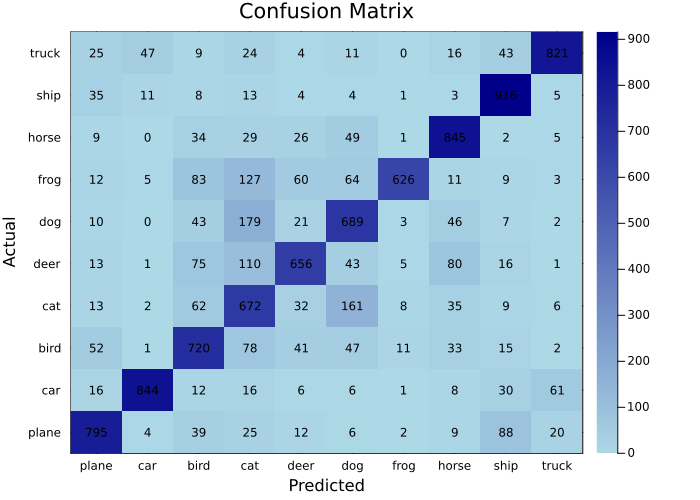

In [66]:
using Plots

cm = zeros(Int,10,10)
for (t,p) in zip(trues, preds)
    cm[t+1,p+1] += 1
end

xs = repeat(1:10, inner=10)
ys = repeat(1:10, outer=10)
txts = string.(vec(cm))

plt = heatmap(
  cm;
  xticks        = (1:10, classes),
  yticks        = (1:10, classes),
  xlabel        = "Predicted",
  ylabel        = "Actual",
  title         = "Confusion Matrix",
  color         = :blues,
  right_margin  = 10Plots.mm,
  annotations   = (xs, ys, txts),
  annotationfontsize = 8,
  annotationfontcolor = :black,
  size          = (700,500),
  framestyle    = :box
)
savefig("plots/confusion_matrix_model_resNet.png")
display(plt)

In [87]:
probs = maximum(model_allcnn(X_test); dims=1)[:]   # max softmax over classes
probs = clamp.(probs, 0, 1)
plt = histogram(
  probs,
  bins=20,
  xlabel="Max softmax probability",
  ylabel="Count",
  title="Histogram pewności predykcji",
  legend=false
)
savefig("plots/prediction_confidence_model_allcnn.png")
display(plt)

OutOfMemoryError: OutOfMemoryError()

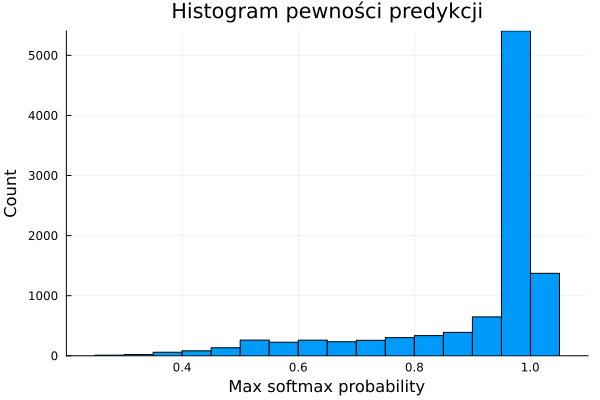

In [88]:
using Plots

function batched_confidences(model, X; batchsize=128)
    N = size(X, 4)
    confidences = Float32[]
    for i in 1:batchsize:N
        j = min(i+batchsize-1, N)
        xb = X[:,:,:, i:j]                  
        ŷ = cpu(model(xb))                  
        append!(confidences, maximum(ŷ; dims=1)[:] )
    end
    return clamp.(confidences, 0f0, 1f0)   
end

probs = batched_confidences(model_allcnn, X_test; batchsize=128)

plt = histogram(
  probs,
  bins=20,
  xlabel="Max softmax probability",
  ylabel="Count",
  title="Histogram pewności predykcji",
  legend=false
)
savefig("plots/prediction_confidence_model_allcnn.png")
display(plt)
